### Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords


from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2  

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

151

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 23.3 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 5s


А теперь в 3 строчки обучим нашу модель

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [14]:
from gensim.models import LdaModel

In [15]:
?LdaModel

In [16]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 31.9 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Посмотрим как выглядят наши темы.
Получим для документа вектор значений (вероятности принадлежности каждой теме)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(4, 0.033144467), (5, 0.17304891), (10, 0.58591604), (24, 0.18565118)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: продукция законодательство связанный сектор денежный работник широкий
topic_1: сша американский новый россия соглашение вопрос кремль
topic_2: первый поток воздух километр запуск испытание активность
topic_3: фонд россия журнал население рост риск погибнуть
topic_4: россия nn млрд российский банк наука система
topic_5: всё очень пенсия день проверка большой рассказывать
topic_6: век белоруссия белорусский золото золотой женский кит
topic_7: украина киев польша украинский донбасс осипов россия
topic_8: исследование эксперт агентство россия nn сша сила
topic_9: проект рынок новый рост инвестор энергия конструкция
topic_10: млн составить экономика температура фестиваль налог тыс
topic_11: выяснить врач больница фотография боль травма необычный
topic_12: санкция космос страдать москва область налоговый департамент
topic_13: мозг пациент болезнь планета рейтинг устойчивый австралия
topic_14: смерть ск россиянин осложнение компьютерный держаться ухо
topic_15: ребёнок nn научный всё 

большинство тем вполне можно описать о чем они

функция, которая будет нам возвращать векторное представление новости

In [20]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.0,0.0,0.903491,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,4896,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.133958,0.0,0.548148,0.000000
2,4897,0.0,0.000000,0.0,0.0,0.033142,0.173164,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.185632
3,4898,0.0,0.075074,0.0,0.0,0.073357,0.374976,0.0,0.0,0.039745,...,0.090566,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.103842,0.000000
4,4899,0.0,0.000000,0.0,0.0,0.762474,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.1268543 , 0.        ,
       0.12796865, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07251277, 0.        , 0.        , 0.03456162,
       0.22184469, 0.        , 0.14463596, 0.        , 0.09551282,
       0.        , 0.05373146, 0.02188189, 0.09031205, 0.        ])

In [25]:
# user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector_max = np.max(user_vector, 0)
    user_vector_mean = np.mean(user_vector, 0)
    user_vector_median = np.median(user_vector, 0)
    return user_vector_max, user_vector_mean, user_vector_median

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [55]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x)[0], 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x)[1], 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x)[2], 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [46]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# # list of text documents
# text = ["The quick brown fox jumped over the lazy dog.",
# 		"The dog.",
# 		"The fox"]
# # create the transform
# vectorizer = TfidfVectorizer()
# # tokenize and build vocab
# vectorizer.fit_transform(text)
# # summarize
# print(vectorizer.vocabulary_)
# print(vectorizer.idf_)
# # encode document
# # vector = vectorizer.transform([text[0]])
# # summarize encoded vector
# # print(vector.shape)
# # print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
[1.69314718 1.28768207 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.        ]


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [56]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [57]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_median = pd.merge(user_embeddings_median, target, 'left')

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [60]:
#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [62]:
logreg_max = LogisticRegression()
logreg_mean = LogisticRegression()
logreg_median = LogisticRegression()
#обучим 
logreg_max.fit(X_max_train, y_max_train)
logreg_mean.fit(X_mean_train, y_mean_train)
logreg_median.fit(X_median_train, y_median_train)

LogisticRegression()

In [63]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_mean = logreg_mean.predict_proba(X_mean_test)[:, 1]

In [33]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [34]:
import itertools

In [65]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best for max Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best for median Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_mean_test, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best for mean Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best for max Threshold=0.332482, F-Score=0.834, Precision=0.808, Recall=0.861
Best for median Threshold=0.257038, F-Score=0.792, Precision=0.706, Recall=0.902
Best for mean Threshold=0.290033, F-Score=0.701, Precision=0.689, Recall=0.714


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1705   50]
 [  35  210]]
Confusion matrix, without normalization
[[1663   92]
 [  25  220]]
Confusion matrix, without normalization
[[1676   79]
 [  71  174]]


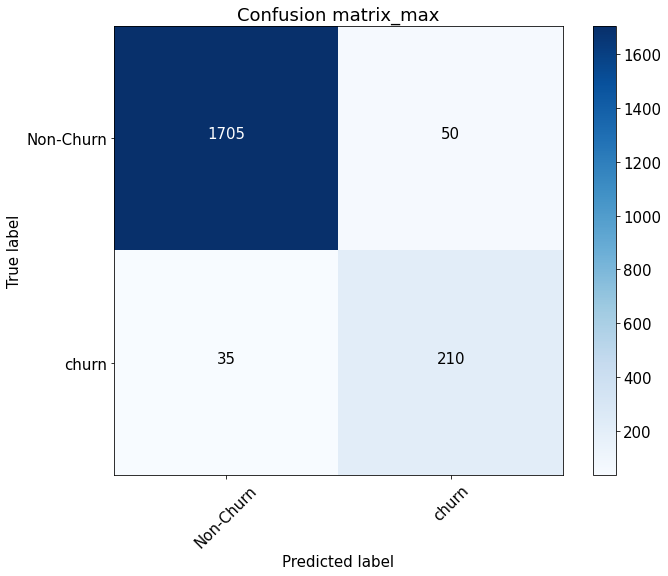

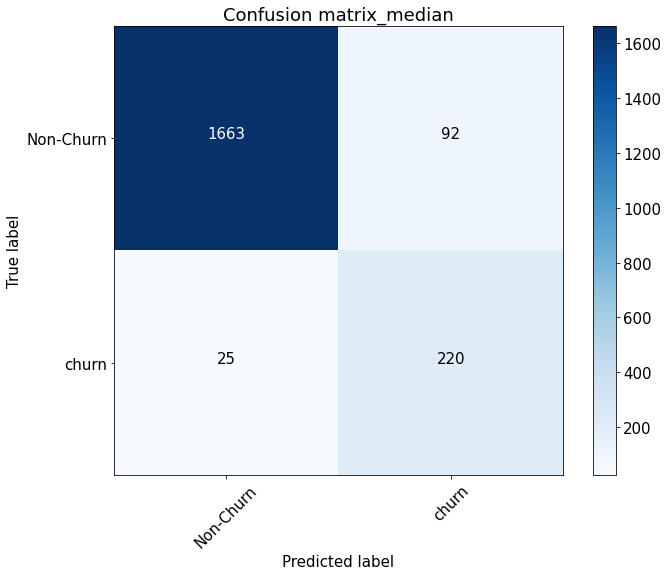

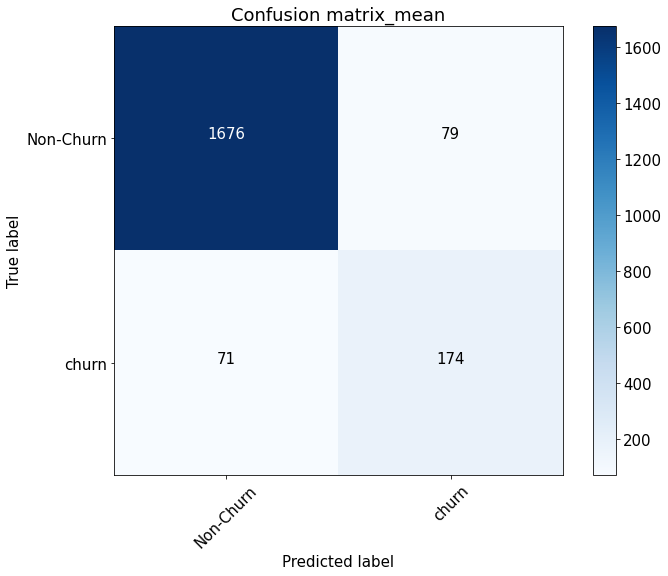

In [67]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_max = confusion_matrix(y_max_test, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_max, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_max')

cnf_matrix_median = confusion_matrix(y_median_test, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_median, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_median')

cnf_matrix_mean = confusion_matrix(y_mean_test, preds_mean>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_mean, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_mean')

plt.savefig("conf_matrix.png")
plt.show()

In [38]:
roc_auc_score(y_max_test, preds_max)

0.9816710273853131

In [39]:
roc_auc_score(y_median_test, preds_median)

0.9787941159369731

In [68]:
roc_auc_score(y_mean_test, preds_mean)

0.9545554974126403

Максимум дает лучшие показатели так как этот вектор содержит наиболее интересуещее пользователя, медиана дает более высокий показатель recall так как охватывает и "второстепенные" для пользователя темы, среднее ожидаемо выдало худший результат. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных